<a href="https://colab.research.google.com/github/Hasama-Twins/DeepLearningHaiku/blob/main/DeepLearningHaiku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import and Process Data



Add this [folder](https://drive.google.com/drive/folders/1xxLhcOfR1TtFq7p7ORBJibDP3ykvpnyn?usp=sharing) to your Google Drive (note: the data should go in "DeepLearningHaikuFolder" in GDrive)

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np

In [6]:
# Sourced from https://www.kaggle.com/datasets/bfbarry/haiku-dataset
lines_df = pd.read_csv('/content/drive/MyDrive/DeepLearningHaikuFolder/lines.txt', sep="/", header=None)
lines_df

,0,1,2
0,delicate savage,you'll never hold the cinder,but still you will burn $
1,our destination,the skyline of this city,shining horizon $
2,a splash and a cry,words pulled from the riverside,dried in the hot sun $
3,hurt but poised for war,sturdy in crestfallen slumps,warrior spirit $
4,steamy mist rising,rocks receiving downward crash,as the jungle weeps $
...,...,...,...
11264,mods removing posts,is reminiscent of days,gone by book burnings $
11265,an otter went down,into the glassy water,to catch her breakfast $
11266,do not waste your time,and know that without failure,you cannot improve $
11267,begging my way back,another night on this road,i gaze at the moon $


In [7]:
without_dollar_sign = lines_df[2].str.rstrip('$')
lines_df[2]=without_dollar_sign
lines_df

,0,1,2
0,delicate savage,you'll never hold the cinder,but still you will burn
1,our destination,the skyline of this city,shining horizon
2,a splash and a cry,words pulled from the riverside,dried in the hot sun
3,hurt but poised for war,sturdy in crestfallen slumps,warrior spirit
4,steamy mist rising,rocks receiving downward crash,as the jungle weeps
...,...,...,...
11264,mods removing posts,is reminiscent of days,gone by book burnings
11265,an otter went down,into the glassy water,to catch her breakfast
11266,do not waste your time,and know that without failure,you cannot improve
11267,begging my way back,another night on this road,i gaze at the moon


In [8]:
lines_df.columns = ["0","1","2"]
lines_df

,0,1,2
0,delicate savage,you'll never hold the cinder,but still you will burn
1,our destination,the skyline of this city,shining horizon
2,a splash and a cry,words pulled from the riverside,dried in the hot sun
3,hurt but poised for war,sturdy in crestfallen slumps,warrior spirit
4,steamy mist rising,rocks receiving downward crash,as the jungle weeps
...,...,...,...
11264,mods removing posts,is reminiscent of days,gone by book burnings
11265,an otter went down,into the glassy water,to catch her breakfast
11266,do not waste your time,and know that without failure,you cannot improve
11267,begging my way back,another night on this road,i gaze at the moon


In [9]:
!pip install tensorflow -q
!pip install imageai --upgrade -q

In [62]:
nature_words = []
with open('/content/drive/MyDrive/DeepLearningHaikuFolder/nature_words.txt') as file:
    nature_words = file.readlines()
nature_words = [word.strip().lower() for word in nature_words]

In [63]:
X = nature_words # keywords from nature ex: rainbow, sun, flower
Y = lines_df.copy() # the lines of the haiku's

### Data Model

In [14]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.9 MB/s eta 0:00:00


In [15]:
import torch
torch.manual_seed(47)
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AdamW, TrainingArguments, Trainer
from transformers import logging
logging.set_verbosity_error()

In [16]:
# Loading GPT2 Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')

In [17]:
# Finding length of maximum token in dataset
lengths = []
for i, row in lines_df.iterrows():
  poem = row[0]+" "+row[1]+" "+row[2]
  lengths.append(len(tokenizer.encode(poem)))
print(max(lengths))

39


In [18]:
class HaikuDataset(Dataset):
  def __init__(self, poems, tokenizer):
    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for i, poem in poems.iterrows():

      encodings_dict = tokenizer("<|startoftext|>"+poem[0]+" / "+poem[1]+" / "+poem[2]+"<|endoftext|>",
                                 truncation=True,
                                 max_length=39,
                                 padding="max_length")
      
      self.input_ids.append(torch.tensor(encodings_dict["input_ids"]))
      self.attn_masks.append(torch.tensor(encodings_dict["attention_mask"]))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [19]:
dataset = HaikuDataset(lines_df, tokenizer)

# Split data into train and validation sets
train_size = int(0.9*len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print("Number of samples for training =", train_size)
print("Number of samples for validation =", val_size)

Number of samples for training = 10142
Number of samples for validation = 1127


## Fine Tune GPT 2 Model for Haikus

In [20]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>',
                                          eos_token='<|endoftext|>', pad_token='<|pad|>')
model = GPT2LMHeadModel.from_pretrained('gpt2').cuda()
model.resize_token_embeddings(len(tokenizer))

Embedding(50259, 768)

In [21]:
training_args = TrainingArguments(output_dir='./results', num_train_epochs=1, logging_steps=100, save_steps=5000,
                                  per_device_train_batch_size=1, per_device_eval_batch_size=1,
                                  warmup_steps=10, weight_decay=0.05, logging_dir='./logs', report_to = 'none')

Trainer(model=model,  args=training_args, train_dataset=train_dataset, 
        eval_dataset=val_dataset, data_collator=lambda data: {'input_ids': torch.stack([f[0] for f in data]),
                                                              'attention_mask': torch.stack([f[1] for f in data]),
                                                              'labels': torch.stack([f[0] for f in data])}).train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 7.0929, 'learning_rate': 4.955586261350178e-05, 'epoch': 0.01}
{'loss': 2.1889, 'learning_rate': 4.9062376628503753e-05, 'epoch': 0.02}
{'loss': 2.1817, 'learning_rate': 4.8568890643505724e-05, 'epoch': 0.03}
{'loss': 2.1792, 'learning_rate': 4.80754046585077e-05, 'epoch': 0.04}
{'loss': 2.2235, 'learning_rate': 4.758191867350967e-05, 'epoch': 0.05}
{'loss': 2.1216, 'learning_rate': 4.708843268851165e-05, 'epoch': 0.06}
{'loss': 2.1305, 'learning_rate': 4.659494670351362e-05, 'epoch': 0.07}
{'loss': 2.2567, 'learning_rate': 4.6101460718515596e-05, 'epoch': 0.08}
{'loss': 2.1305, 'learning_rate': 4.560797473351757e-05, 'epoch': 0.09}
{'loss': 2.1649, 'learning_rate': 4.511448874851954e-05, 'epoch': 0.1}
{'loss': 2.215, 'learning_rate': 4.462100276352152e-05, 'epoch': 0.11}
{'loss': 2.1434, 'learning_rate': 4.412751677852349e-05, 'epoch': 0.12}
{'loss': 2.0893, 'learning_rate': 4.363403079352547e-05, 'epoch': 0.13}
{'loss': 2.0855, 'learning_rate': 4.314054480852744e-05, 'epoch'

TrainOutput(global_step=10142, training_loss=2.08999085769548, metrics={'train_runtime': 856.8106, 'train_samples_per_second': 11.837, 'train_steps_per_second': 11.837, 'train_loss': 2.08999085769548, 'epoch': 1.0})

## Generate Haikus


In [22]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install syllables -q
import syllables

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.3/939.3 kB 15.3 MB/s eta 0:00:00


In [23]:
# Determines whether a poem follows haiku 5-7-5 syllable structure
def is_haiku_syllables(poem):
  haiku_syllables = [5,7,5]
  lines = poem.split(" / ")

  if len(lines) != 3:
    return False
    
  for i, line in enumerate(lines):
    words = line.strip().split()
    count = sum([syllables.estimate(word) for word in words])

    if count != haiku_syllables[i]:
      return False

  return True

In [59]:
print(is_haiku_syllables("container ship sails / through winds gust blowing the trees / like a tide on earth")) # true 
print(is_haiku_syllables("container ship sails / through winds gust blowing the trees / like a tide on the earth")) # false

True
False


In [60]:
def generate_haikus(word):
  gen_haikus = []

  prompt = "<|startoftext|>" + word
  generated = tokenizer(prompt, return_tensors="pt").input_ids.cuda()
  
  sample_outputs = model.generate(generated, do_sample=True, 
                                  max_length=39, temperature=0.8, num_return_sequences=100, early_stopping=True)
  for i, sample_output in enumerate(sample_outputs):
    poem = tokenizer.decode(sample_output, skip_special_tokens=True)
    if is_haiku_syllables(poem):
      gen_haikus.append(poem)

    # generate at most 3 haikus per prompt
    if len(gen_haikus)>=3:
      break

  return gen_haikus

In [64]:
# generate haikus from nature words
generated_haikus = []
for word in X:
  generated_haikus += generate_haikus(word)

In [65]:
# display 20 randomly generated poems
rand_generated_poems = random.sample(generated_haikus, 20)
for poem in rand_generated_poems:
  print(poem)

quiet evenings fall  /  the first thing you ever do  /  is to get dressed 
snow falling over  /  a tree falling on the earth  /  as the sun rises 
desert in my heart  /  my life is under attack  /  with the little ones 
tornado strikes  /  my heart flutters on and then  /  the wind blows my back 
butterfly buzzing  /  oh my it is amazing  /  just a little girl 
starving on a couch  /  i need to make some money  /  i'm not that stupid 
bee's always here  /  her scent of white flowers  /  is the best she's left 
bright sky above  /  the cool breeze keeps me warm  /  i am now sleepless 
glacier with my face  /  a warm smile says nothing  /  i miss you all time 
wet leaves and rain  /   a warm embrace with joy  /   oh my love and joy 
rainbow and the sun  /  this will likely make it  /  or will it be rain 
meadow between two  /  an oasis that waits for you  /  not waiting for you 
rockets in the sky  /   as i look down down on you  /   you can hear me now 
valley of the sun  /  a distant l

# Evaluate Poems using BERTScore



In [47]:
!pip install bert_score -q
import torch
from bert_score import score
import random

In [66]:
reference_poems = lines_df.values.tolist()
reference_poems = [" / ".join(poem_lines) for poem_lines in reference_poems]

def calculate_bert_score(generated_poem):

  # 10 random reference poems
  rand_reference_poems = random.sample(reference_poems, 20)

  # Compute the BERTScore for the generated poem relative to the reference poems
  P, R, F1 = score([generated_poem], [rand_reference_poems], lang='en', model_type='bert-base-uncased')

  # return the mean F1 score as a measure of the poem's quality
  return round(float(F1.mean()),2)

In [67]:
# display some poems and their bert scores
rand_generated_poems = random.sample(generated_haikus, 20)
for poem in rand_generated_poems:
  print(poem, ": ", calculate_bert_score(poem))

wind of cold storm clouds  /   rain makes a perfect storm  /   rain falls on spring's end  :  0.51
dry and wet all day  /  i have left my dog with you  /  i just didn't know you  :  0.55
mountain on the hill  /  a branch slaps at the edge  /  and i reach over  :  0.53
warm and warm with you  /  your love and the warmth with you  /  i am sorry but  :  0.54
rockets in the sky  /   as i look down down on you  /   you can hear me now  :  0.54
ocean waves drown  /  the waves slowly break free  /  waves in a lake  :  0.54
aurora the moon  /  in the same spot alone  /   the moon of moonlight  :  0.57
green leaves sprout out  /  orange leaves sprout out  /  orange blossoms  :  0.51
meadow is so dark  /  i have lost my mind and soul  /  i could fly away  :  0.58
tornado's hot bed  /   hot bed was soaked with red  /   wet wet wet and dry  :  0.49
sunny night at night  /  i am sitting in my room  /  happy and happy  :  0.55
quiet morning breeze  /  the wind has stopped cold nights  /  the spring 

In [68]:
from statistics import mean

# calculate score for all poems
average_bert_score = mean([calculate_bert_score(poem) for poem in generated_haikus])
print("Average BERTScore across all generated haikus: ",average_bert_score)

Average BERTScore across all generated haikus:  0.5507407407407408


In [69]:
print(len(generated_haikus),"generated haikus from", len(X),"keywords")

162 generated haikus from 60 keywords


# Application: Generate Haiku from Images


In [70]:
from imageai.Classification import ImageClassification
import os
import cv2
from matplotlib import pyplot as plt

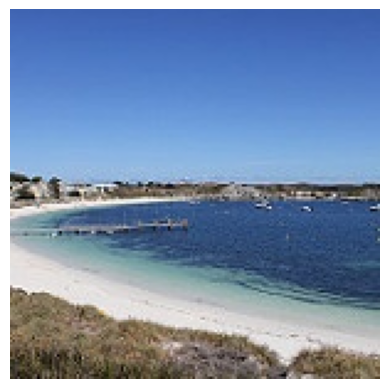

(0.55, 'seashore was last  /  when i was younger but not  /  we were never ')
(0.55, 'sandbar on the floor  /    a small bird in the water  /   waiting for the next ')


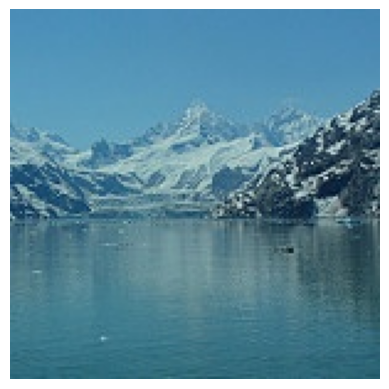

(0.56, 'lakeside hills  /  all yearning for springtime  /  the trees in the hills ')
(0.57, 'valley of flowers  /  the flowers of the forest  /  on the riverbanks ')


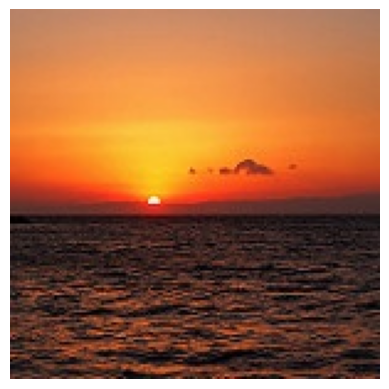

(0.56, 'seashore is still  /    i am going to go to sleep  /   i know what i need ')
(0.56, "drilling platforming  /  we found a place with you  /  and now i'm bored ")


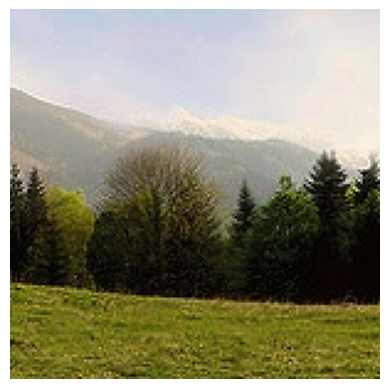

(0.55, 'alpaca is now  /  the world is now a prison  /  and it will be fine ')
(0.56, 'valley of my dreams  /   a dream is an illusion  /   in this world is true ')


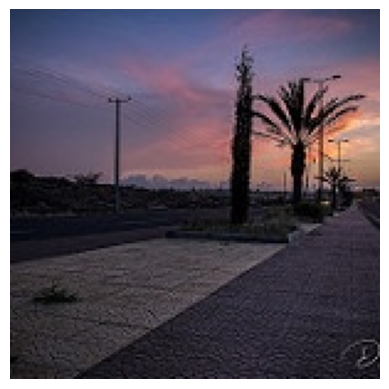

(0.55, "lakeside air  /   in the heat of fire and grass  /   it's all about you ")
(0.56, 'planetarium earth  /  a bird chirping in a tree  /  watching the sunset ')


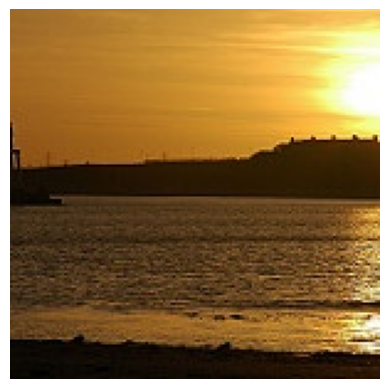

(0.54, 'seashore orchard  /  orchard of blooming leaves  /  with the same leaves ')
(0.56, 'breakwater is cold  /  warm in the sun you have it  /  cold in the desert ')


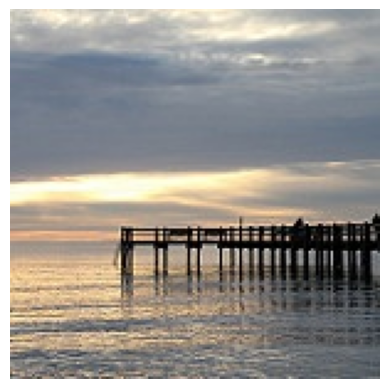

(0.59, 'piercing of the stars  /   i am unable to see  /   in the sky full moon ')
(0.56, 'dock with a bottle  /   the red bottle is burning  /   to get my teeth clean ')


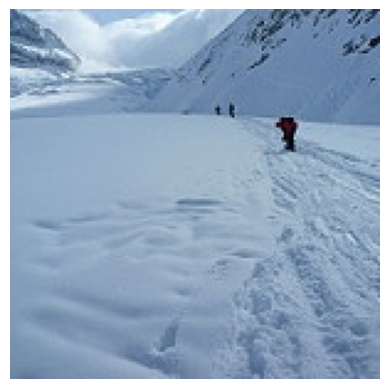

(0.54, 'alporn in my hand  /  when i get a cold bottle  /  the bottle is warm ')
(0.56, 'skiing down the slopes  /  a snowflake in my head  /  my dream of being snow ')


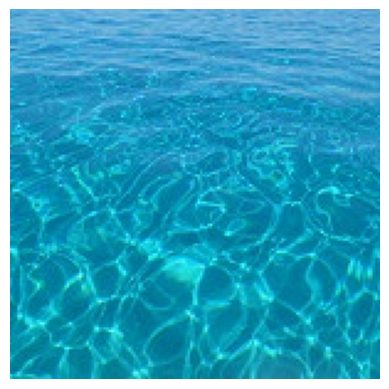

(0.6, 'loggerhead lizards  /  in the dark clouds of winter  /  the frost will be gone ')
(0.55, 'stingray tree and oak  /   to the side of the river  /   in the afternoon ')


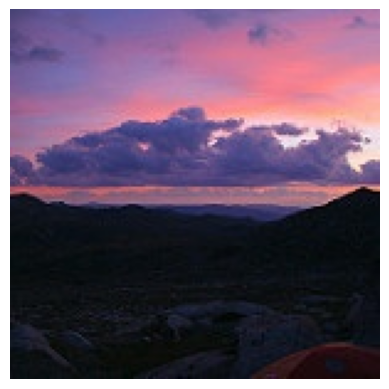

(0.57, 'mountain tentacle  /   with this green flame they grow  /   all about to rise ')
(0.58, 'volcano of man  /   the sky is a cloudy night  /   the sun is a cloud ')


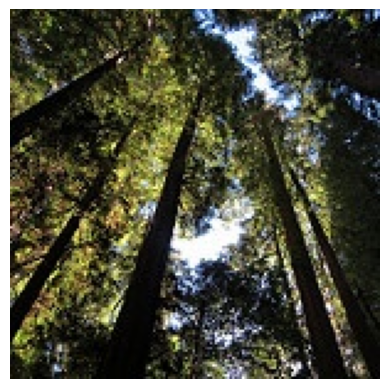

(0.58, 'safety pinions  /  my hands keep my eyes closed  /  waiting for the wind ')
(0.52, 'sundial nature  /  no other reason for life  /  then you start to laugh ')


In [75]:
# https://imageai.readthedocs.io/en/latest/prediction/index.html

path = '/content/drive/MyDrive/DeepLearningHaikuFolder/'
prediction = ImageClassification()
prediction.setModelTypeAsResNet50()
prediction.setModelPath(path+ "resnet50-19c8e357.pth")
prediction.loadModel()

# Sourced from https://www.kaggle.com/datasets/puneet6060/intel-image-classification

images_path = '/content/drive/MyDrive/DeepLearningHaikuFolder/test_images'

for i, filename in enumerate(os.listdir(images_path)):
    if filename.endswith("jpg"): 
        file_path = images_path+"/"+filename

        # get 2 keywords from each image 
        predictions, probabilities = prediction.classifyImage(file_path, result_count=2)

        # display image
        img_color = cv2.imread(file_path)
        img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
        plt.imshow(img_color)
        plt.axis("off")
        plt.show()

        for pred in predictions:
          haikus = generate_haikus(pred)
          haiku_and_score = [(calculate_bert_score(poem),poem) for poem in haikus]
          haiku_and_score.sort(reverse=True)
          # print highest bert scoring haiku
          print(haiku_and_score[0] if haiku_and_score else "")
